# Tumor Classification Project

### Description:

The purpose of this project is the employ computer vision and a CNN in order to classify MRI images of brains with and without tumors. The primary purpose is to train the model on a binary classifier (tumor or no tumor), then secondarily to classify the type of tumor if one is present.

### Dataset:
https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

The data set provides the MRI images in their own folders of either 'yes' or 'no' (referring to if the scan contains a tumor). There are 154 images in the yes folder (tumor) and 91 in the no folder (healthy).

### Importing Packages

In [1]:
#Importing primary packages
import numpy as np
import torch
import glob
import cv2
import seaborn as sns

#Importing Dependencies
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import sys

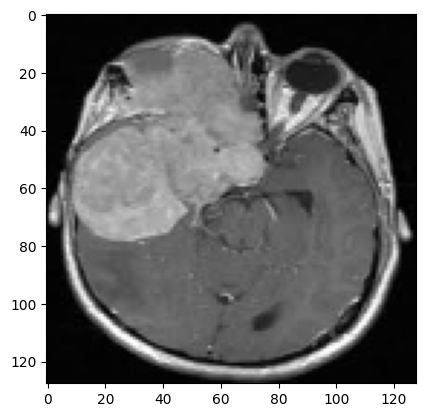

In [ ]:
#Opening one of the images
plt.imshow(tumor[8])

### Creating The Model

*Note*: This is something that I think I need to improve upon, PyTorch now has functions that are able to load in the data, so I want to see if there is a better way to load in the data without having to make these classes. ALSO, the data loading that I can notice is wants to directly take in the training, test, and validation sets (which I would need to produce myself).

In [ ]:
class MRI(Dataset):
    """
        Initializing the model
        Data reading and standardizing the sizes
        Concatenating the data and applying labels
        Defining length, getitem, and normalization functions
    """
    def __init__(self):
        tumor = []
        healthy = []

        #Then iterating over all images and appending them to the empty lists
        for f in glob.iglob('C:/Data/brain_tumor_dataset/yes/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img, (128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) #shape would've been (h, w, #of channels)
            tumor.append(img)

        for f in glob.iglob('C:/Data/brain_tumor_dataset/no/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img, (128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        #Creating arrays from the images
        healthy = np.array(healthy, dtype=np.float32)
        tumor = np.array(tumor, dtype=np.float32)

        #Creating the labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        #Concatenating the data
        self.images = np.concatenate((tumor,healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    #function creation for pytorch default abstract class
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

### Defining Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential( #starting dimension (128, 128, 3)
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1) #ends with 1 feature, since we are detecting essentially 1 class (has tumor or not)
        )
    
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = torch.sigmoid(x)
        return x


### Training the model

In [ ]:
#Faster computing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda')
model = CNN().to(device)

Using cuda device


In [ ]:
eta = 0.0001 #speed of model training
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True) 
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [22]:
epoch = 400
for E in range(1, epoch): 
    losses = []
    for D in dataloader:
        optimizer.zero_grad() #important to call at the beginning of the epoch
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)

        #error/loss calc
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (E+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(E+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.106863
Train Epoch: 20	Loss: 0.097774
Train Epoch: 30	Loss: 0.088976
Train Epoch: 40	Loss: 0.080545
Train Epoch: 50	Loss: 0.072550
Train Epoch: 60	Loss: 0.065048
Train Epoch: 70	Loss: 0.058083
Train Epoch: 80	Loss: 0.051684
Train Epoch: 90	Loss: 0.045865
Train Epoch: 100	Loss: 0.040624
Train Epoch: 110	Loss: 0.035943
Train Epoch: 120	Loss: 0.031791
Train Epoch: 130	Loss: 0.028130
Train Epoch: 140	Loss: 0.024914
Train Epoch: 150	Loss: 0.022098
Train Epoch: 160	Loss: 0.019634
Train Epoch: 170	Loss: 0.017481
Train Epoch: 180	Loss: 0.015598
Train Epoch: 190	Loss: 0.013950
Train Epoch: 200	Loss: 0.012506
Train Epoch: 210	Loss: 0.011237
Train Epoch: 220	Loss: 0.010121
Train Epoch: 230	Loss: 0.009137
Train Epoch: 240	Loss: 0.008266
Train Epoch: 250	Loss: 0.007495
Train Epoch: 260	Loss: 0.006810
Train Epoch: 270	Loss: 0.006200
Train Epoch: 280	Loss: 0.005656
Train Epoch: 290	Loss: 0.005169
Train Epoch: 300	Loss: 0.004732
Train Epoch: 310	Loss: 0.004339
Train Epoch: 320	

My losses are relatively inconsistent, sometimes the loss ends at ~.40 and sometimes it ends at ~0.006. I think that this can be alleviated with both more epochs and a different model architecture.

### Evaluating the model

In [24]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad(): #this is j temporary for testing, w/o gradients
    for D in dataloader:
        image = D['image'].to(device) #that bit after the . is prob a great coding practice to make sure that the model gets loaded on whoever wants to run it
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy()) #this is appending results of the model as a copy on the cpu
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis=0).squeeze() #need the squeeze for proper dimensionality
y_true = np.concatenate(y_true, axis=0).squeeze()

In [25]:
def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [26]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

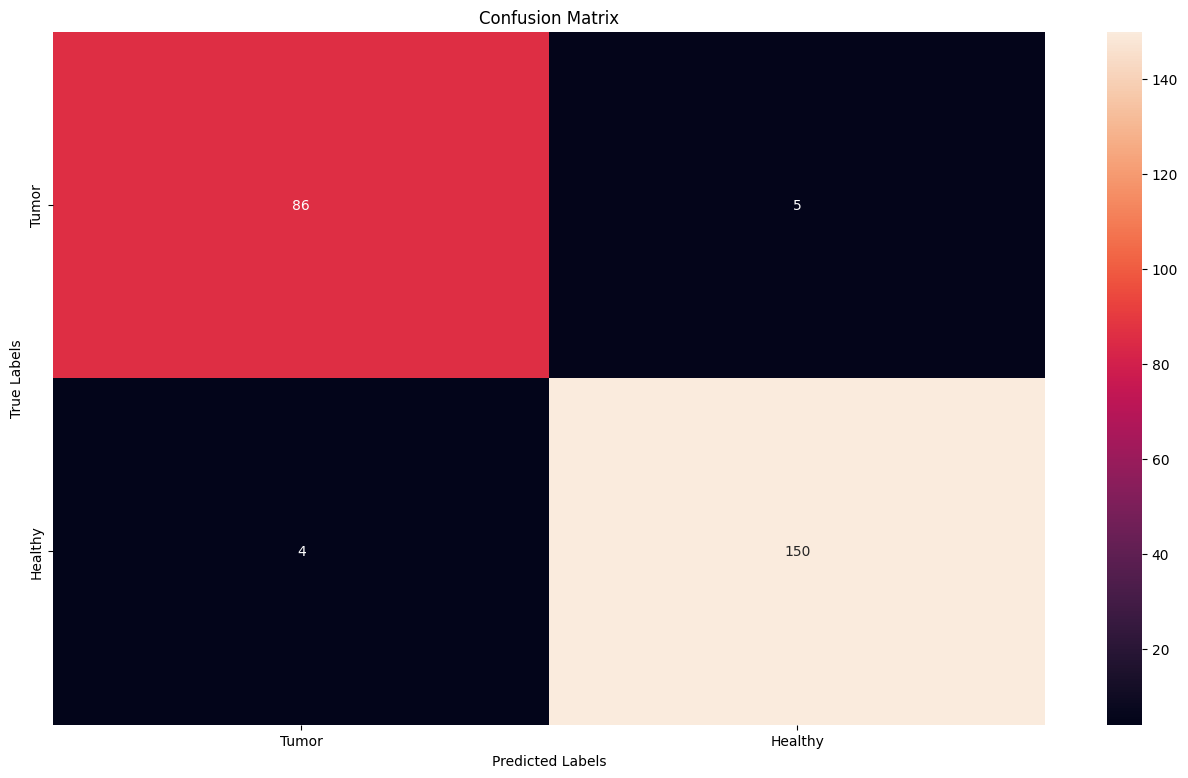

In [19]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

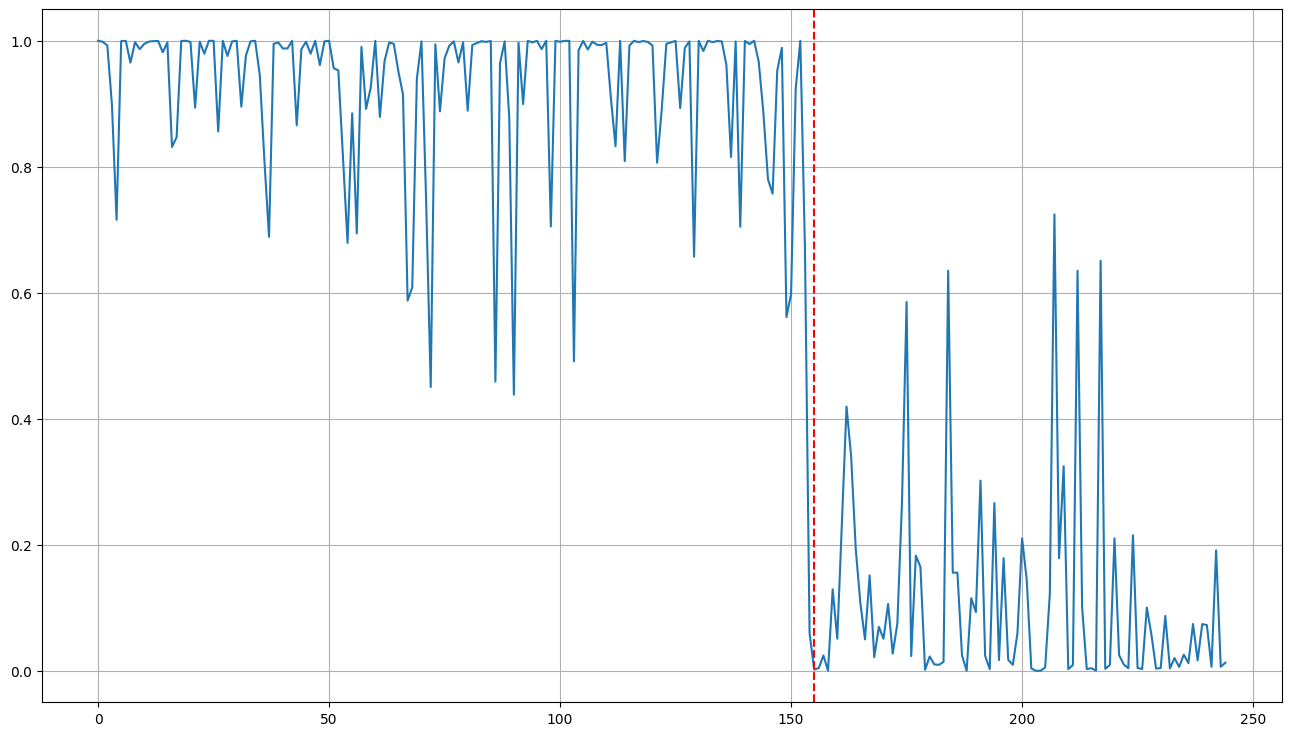

In [21]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=155, color='r', linestyle='--')
plt.grid()